#### Last Modified: Nov 16th, 2021 (Opal). 

# OpInf on MHD Solar Wind Radial Speed dataset


In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
import numpy as np 
import time
import astropy.units as u

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

In [3]:
from code.hux_propagation import *
from code.archimedes_sprial import compute_phi_shift_forward
from code.numerical_methods import apply_numerical_method

# Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr="2210")
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
n = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [7]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

# Define a new grid $[r,\phi]$

In [8]:
p_new = np.linspace(p[0], p[-1], 1000)
r_new = np.linspace(r[0], r[-1], 1000)

f_new = np.zeros((len(p_new), len(r_new)))

In [9]:
v_interp = interp2d(p, r, f[:, 55, :].T, fill_value="extrapolate")
f_new = v_interp(p_new, r_new).T

In [10]:
V = f_new

In [11]:
r = r_new
p = p_new

# Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

# Reduced Order Model

We begin by assuming that the solar wind motion is described by the fluid momentum equation in corotating frame of reference.

\begin{equation} \label{momentum-equation}
-\Omega_{\text{rot}} \frac{\partial v}{\partial \phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P - \frac{G M_{s}}{r^2}e_{r}
\end{equation}

Where $v$ is the solar wind velocity, $\rho$ is the proton mass density, $P$ is the thermal pressure, $G$ is the gravitational constant, $r$ is the radial distance from the Sun, and $M_{s}$ is the solar mass. Unlike the conventional momentum equation, this Eq is time-stationary, in which the derivative with respect to time $\frac{\partial v}{\partial  t}$ in the conventional momentum equation has been swapped with $-\Omega_{\text{rot}}\frac{\partial v}{\partial  \phi}$ term. By neglecting the pressure gradient and gravity terms, which are assumed to be small in the heliosphere, the fluid momentum equation reduces to a nonlinear scalar homogeneous time-stationary equation, described by 

\begin{equation} \label{model}
\frac{\partial v}{\partial \phi} -\frac{1}{\Omega_{\text{rot}}}v\frac{ \partial v}{\partial r}=0
\end{equation}

where $r$ denotes the radial distance from the Sun,  $\phi$ denotes Carrington longitude in Heliographic (rotating) coordinate system (HG), and $v$ is the solar wind velocity in the radial direction. The initial-boundary value problem, or Cauchy problem with periodic initial data, is defined by Eq above on the domain $ r \geq 30 R_\odot$, $0 \leq \phi \leq 2 \pi$, where $\Omega_{\text{rot}}$ is the angular frequency of the Sun's rotation set equal to $\frac{2 \pi}{25.38} \text{1/days}$ at the solar equator, and more generally is a function of latitude.

\begin{equation} \label{omega-rot}
\Omega_{\text{rot}} (\theta) = \frac{2\pi}{25.38} - \frac{2.77\pi}{180} \cos(\theta)^2
\end{equation}

The two-dimensional model is subject to the initial condition
\begin{equation} \label{ic}
v(\phi, r_{0}) = v_{r_{0}}(\phi)
\end{equation}

with periodic boundary conditions, such that $v(0, r) = v(2\pi, r)$, for all radial locations. The underlying Eq would be considered in the form of the well-studied inviscid Burgers' equation if the propagation was in $\phi$ direction, although we are advancing in the radial direction; For instance, given an initial condition at $30 R\odot$, what is the solar wind speed near Earth at $1\text{AU}\approx 215R_\odot$? Now that we defined the problem, we are in the position to explore mathematical methods to solve our underlying equation. 


We can rewrite the underlying Eq in hyperbolic conservation  form

\begin{equation} \label{conservative-form}
    v_{r} + [f(v)]_{\phi} = 0 
\end{equation}

where the subscripts $r$ and $\phi$ denote the partial derivatives. The physical flux function is $f(v) = -\Omega_{\text{rot}} \ln(v)$ and because $f''(v) = \frac{\Omega_{\text{rot}}}{v^2} > 0$ $\forall v$, $f$ is said to be convex. When $f''(v)$ does not change signs, discontinuous solutions appear in the form of either compression or an expansion wave. 

Then, we can leverage the "upwind" scheme to approximate the derivative with respect to $\phi$ such that

$$
[f(v)]_{\phi} \approx \frac{-\Omega_{\text{rot}}}{\Delta \phi}  [\ln(v_{i, j + 1}) - \ln(v_{i, j})]
$$

where

$$
\begin{align*}
    A &= \frac{\Omega_{\text{rot}}}{\Delta \phi} \left[\begin{array}{ccccc}
        -1 & 1 & & & \\
        0 & -1 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & & -1 & 1 \\
        1 & & & 0 & -1 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    \mathbf{v}_0  \in\mathbb{R}^{n}.
\end{align*}
$$


we obtain the semi-discrete system

$$
\frac{d}{dr}\mathbf{v}(\phi, r) = A\ln(\mathbf{v}(\phi, r)),
$$


# Lagrangian reduced-order models

Many reduced order modeling techniques such as the Dyanmic Mode Decompostion, Proper Orthogonal Decomposition, and Operator Inference all rely on the Singular Value Decomposition (SVD) of the snapshot dataset. For translation problems, such as the problem described above of solar wind streams traveling in the heliosphere, yields to poorly reducing singular values since the modes are being averaged over all shifted solutions. The main problem lies in the translation. Although the flow has a relatively simple structure it fails to be captured by a small amount of the spatial modes. 

The main challenges as the translational property and the nonlinearity of the governing equations. Using the method of characteristics as a reference frame can solve the translational issue yet is only valid **before** a shock is formed. 
Lu et al [2] developed a physics-aware DMD method that retains information about shock formation. 




### Lagrangian Framework (Lu et al [1])

The method of characteristics can be applied to quasi-linear partial differential equations (PDEs). The underlying PDE can be rewritten in quasi-linear form as 

\begin{equation} \label{gform}
\frac{\partial v}{\partial r} - \frac{\Omega_{rot}}{v} \frac{\partial v}{\partial \phi} = 0
\end{equation}


Then, by the method of characteristics, 
\begin{equation}
\frac{\partial v}{\partial r} = 0
\end{equation}

If 
\begin{equation} \label{vline}
\frac{\partial \phi}{\partial r} = -\frac{\Omega_{rot}}{v}
\end{equation}

Hence, given this ansatz, the underlying PDE reduces to two coupled ordinary differential equations, and the characteristics may be obtained by integrating the equation above. As a result, the velocity remains constant along each characteristic and can be verified by

\begin{equation}
    \begin{split}
        \frac{d}{d r} v(r, \phi) & = \frac{\partial}{\partial r} v(r, \phi)  + \frac{\partial}{\partial \phi} v(r, \phi) \frac{\partial \phi}{\partial r} \\ & =  \frac{\partial}{\partial r} v(r, \phi)  + \frac{\partial}{\partial \phi} v(r, \phi) \cdot (-\frac{\Omega_{rot}}{v})\\ & = 0
    \end{split}
\end{equation}

Then by integrating the Eq above with respect to $r$, the characteristic are straight lines described by 

\begin{equation} \label{characteristic-curves}
\Delta \phi = -\frac{\Omega_{rot}}{v}  (\Delta r)
\end{equation}

where the solution of the first order propagating wave has a wave speed of $-\frac{\Omega_{rot}}{v}$. This approximation is called the *ballistic* approximation. It assumes that each parcel of plasma continues at a constant speed $v$ through out the heliosphere. The ballistic approximation holds when characteristic lines do not intersect. It is usually applied to mapping solar wind streams for short radial distances. 


## **References**

[1] *Lu, Hannah & Tartakovsky, Daniel. (2020). 'Lagrangian Dynamic Mode Decomposition for Construction of Reduced-Order Models of Advection-Dominated Phenomena'. Journal of Computational Physics.*

[2] *Lu, Hannah & Tartakovsky, Daniel. (2021). Dynamic Mode Decomposition for Construction of Reduced-Order Models of Hyperbolic Problems with Shocks. Journal of Machine Learning for Modeling and Computing.*

[3] *Sesterhenn, Jörn & Shahirpour, Amir. (2016). A Lagrangian Dynamic Mode Decomposition.*



In [12]:
def plot_heat_data(Z, title, sample_columns=np.arange(0, len(r), 50), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p_new*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(str(variable) + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=300, bbox_inches='tight')

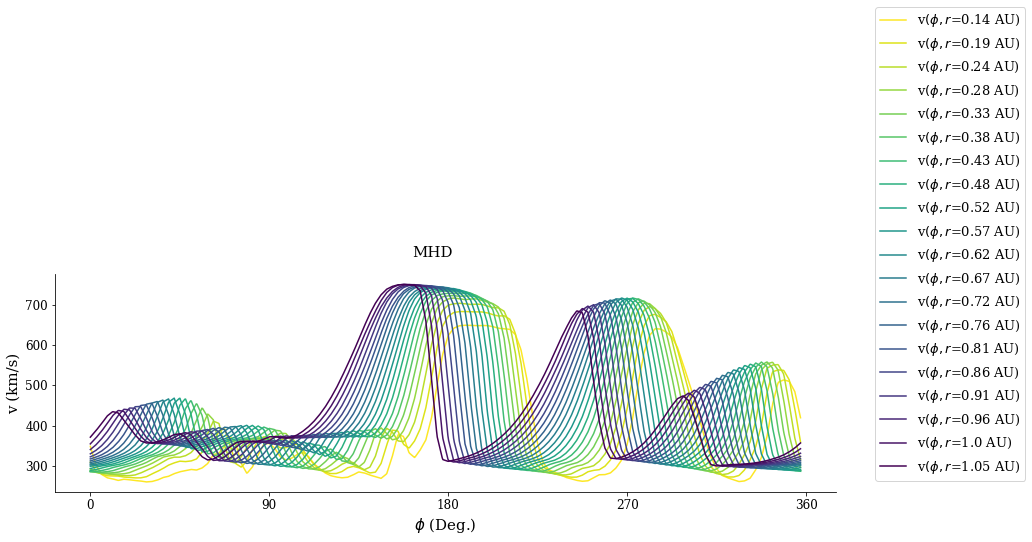

In [13]:
plot_heat_data(V, "MHD", variable="v", save_fig=True, file_name="figs/original_dataset_MHD.png")

# Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [14]:
# set up the first l indexes used for training. 
l = int(0.8*(len(r)))

In [15]:
X= V

In [16]:
X_train = V[:, :l]
X_test = V[:, l:-1]

In [17]:
r_train = r[:l]
r_test = r[l:-1]

In [18]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (1000, 800)
Radial distance train: 0.13951401782886472 AU to 0.9083912966443735 AU

X test shape (1000, 199)
Radial distance test: 0.9083912966443735 AU to 1.0996495197497314 AU


## Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

## Using the ROM Operator Inference Package
Since the FOM has the form
$$
    \frac{d}{dt}\mathbf{x}(t) = A \ln (\mathbf{x}(t)),\qquad\mathbf{x}(0) = \mathbf{x}_0,
$$
we seek a reduced model with that same structure,
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$

but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Esentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind proton velocity at several heliocentric distances. 

We have several tasks to consider:
1. Choosing the reduced-model dimension $r$,
2. Constructing a low-dimensional subspace,
3. Computing the right-hand side data matrix $\dot{X}$,
4. Constructing the ROM via Operator Inference,
5. Simulating the ROM, and
6. Evaluating the performance of the ROM.

We will do this quickly, then show each step in more detail.

### Step 1: Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [19]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(V[:, :l])

In [20]:
# Calculate the cumulative energy.
thresh = .99
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 9
r (Eularian coordinates)= 9


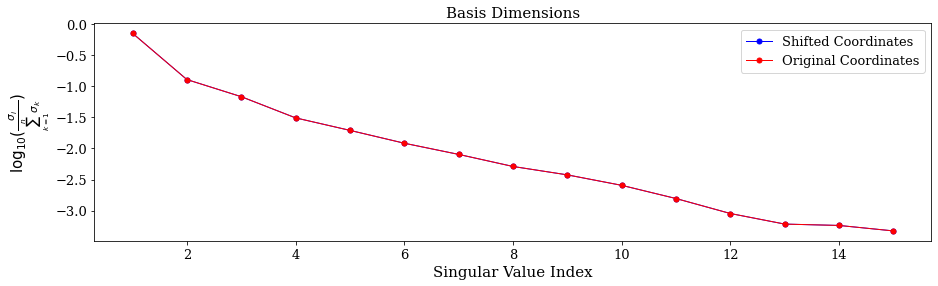

In [21]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), np.log10(svdvals[:15]/ np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), np.log10(svdvals_prev[:15]/ np.sum(svdvals_prev)), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")


plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}})$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

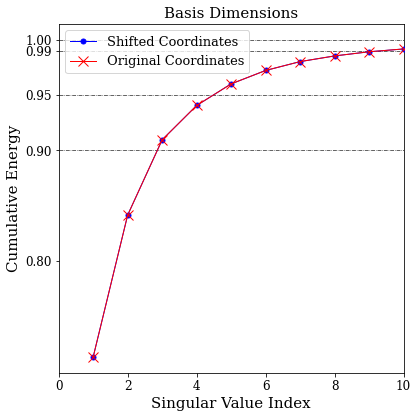

In [22]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(6, 6))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
#ax.vlines(rank, 0, thresh, color="blue", linewidth=.6, linestyle="-.")
#ax.vlines(rank_prev, 0, thresh, color="red", linewidth=.6, linestyle="-.")


# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
plt.savefig("figs/singular_value_decay.png", pad_inches=1)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [23]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (1000, 9)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

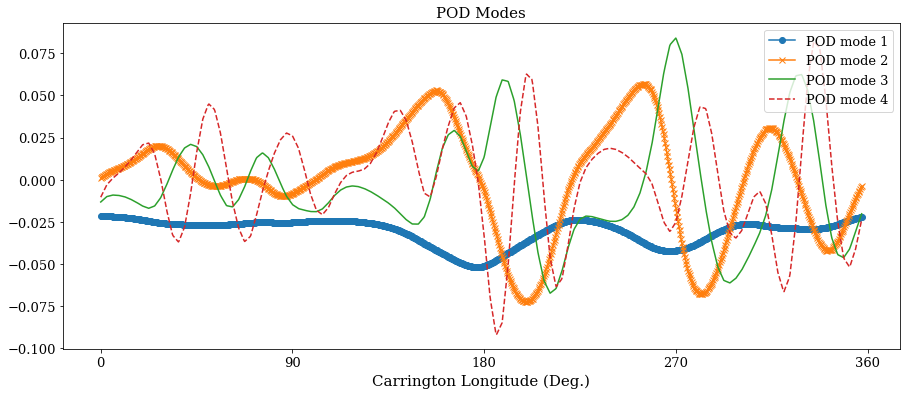

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot((180/np.pi) * p, Vr[:len(p),0], "-o", label=f"POD mode {1}")
ax.plot((180/np.pi) * p, Vr[:len(p),1], "-x", label=f"POD mode {2}")
ax.plot((180/np.pi) * p, Vr[:len(p),2], "-", label=f"POD mode {3}")
ax.plot((180/np.pi) * p, Vr[:len(p),3], "--", label=f"POD mode {4}")
#ax.plot((180/np.pi) * p_new, Vr[:len(p_new),4], "-", label=f"POD mode {5}")


    
ax.set_xlabel("Carrington Longitude (Deg.)", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
plt.legend(loc="upper right")
plt.show()

In [25]:
roi.pre.projection_error(X_train, Vr)

0.004651806084909398

### Calculating the right-hand side Data Matrix

Operator Inference constructs the ROM by solving a least-squares problem that corresponds to the form of the model.
In this case, the original model has the form $\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t)$.
The snapshot matrix $X$ contains data for $\mathbf{x}(t)$, but we also need data for $\frac{d}{dt}\mathbf{x}(t)$.
In this simple example, we can directly compute the _snapshot time derivative matrix_ $\dot{X}\in\mathbb{R}^{n\times k}$ that corresponds to the snapshots by setting $\dot{X} = A X$.

\If the matrix $A$ is unknown or computationally unavailable, the time derivative matrix can be estimated through finite differences of the snapshots.
The `pre` submodule has some convenience tools for this.
Since our time domain is uniformly spaced, we use `roi.pre.xdot_uniform()`; for snapshots that are not uniformly spaced in time, see `roi.pre.xdot_nonuniform()`.

We also note that the finite difference approximation for $\dot{X}$ commutes with the projection to a low-dimensional subspace; in other words, $V_{r}^\mathsf{T}\frac{d}{dt}\left[X\right] = \frac{d}{dt}\left[V_{r}^\mathsf{T}X\right]$.
To save memory, the snapshot matrix may be projected first, and the projected time derivatives can be calculated from the projected snapshots.
The ROM classes in the next section accept both full-order ($n \times k$) or reduced-order ($r\times k$) snapshot and time derivative matrices as training data.

In [26]:
X_ = Vr.T @ X_train                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (r[1]-r[0]).value, order = 6) # Estimate the projected time derivatives.

In [27]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


We now fit the model to the data by solving the least squares problem
$$
    \min_{\hat{A}\in\mathbb{R}^{r\times r}}\left\|\hat{A}\hat{X} - \dot{\hat{X}}\right\|_{F}^2,
$$
where
$$
\begin{align*}
    \hat{X} &= V_r^\mathsf{T}X,
    &
    \dot{\hat{X}} &= V_r^\mathsf{T}\dot{X}.
\end{align*}
$$
This is all done in the `fit()` method, given $X$, $\dot{X}$, and $V_r$.

In [28]:
model.fit(Vr, X_train, Xdot_, P=1e2)

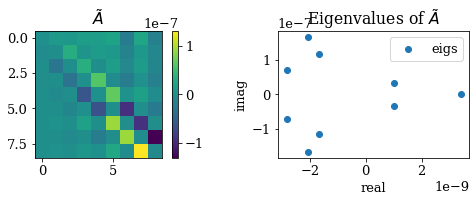

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)

_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [30]:
X_ROM = model.predict(X[:, 0], r.value, method="BDF")
X_ROM.shape

(1000, 1000)

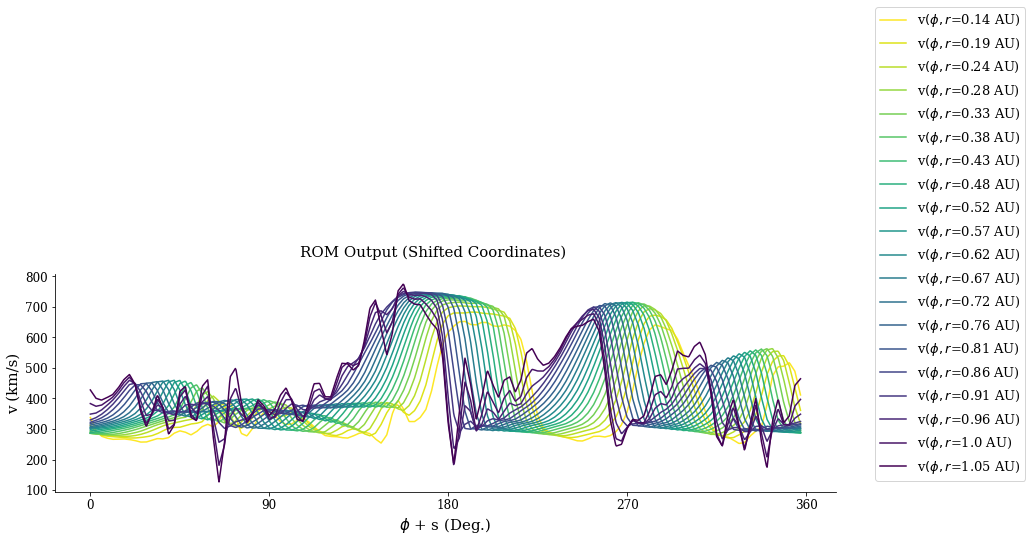

In [31]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel=r"$\phi$ + s (Deg.)")

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

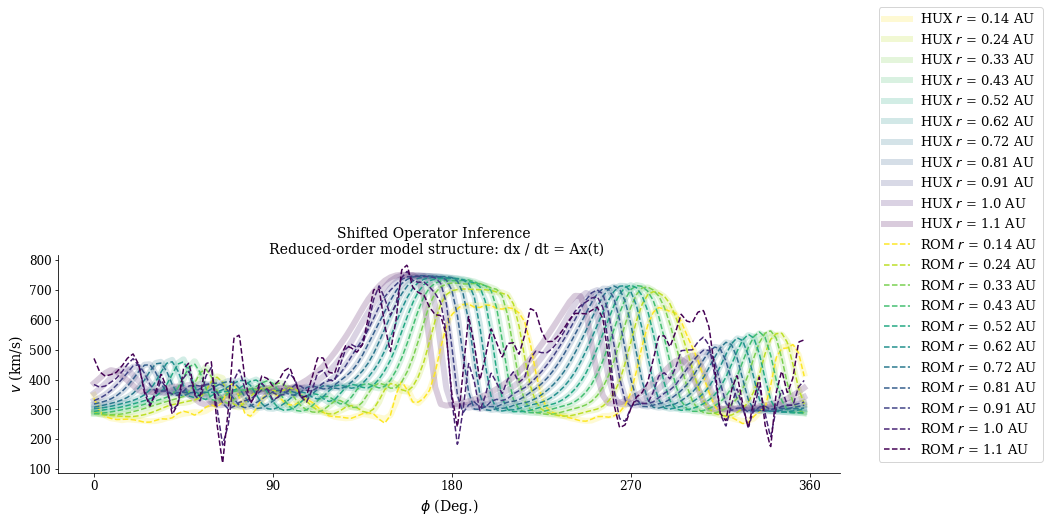

In [32]:
sample_columns = np.arange(0, len(r), int(len(r)//10))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p_new*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p_new*(180/np.pi), X_ROM[:,j], "--", color=curr_color, label=rf"ROM $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=14)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("figs/opinf_results_mhd_A.png", dpi=500, bbox_inches='tight')


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

In [33]:
V_ROM = X_ROM

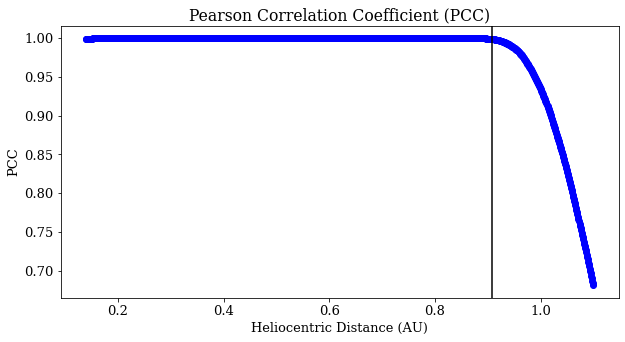

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")

plt.savefig("figs/pcc_operator_inference_mhd_A.png")

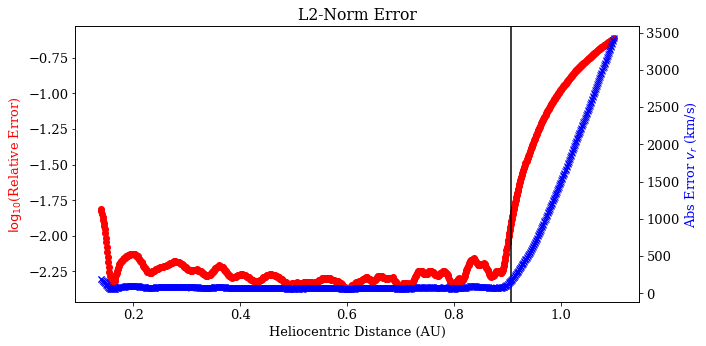

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [36]:
abs_froerr, rel_froerr = roi.post.frobenius_error(V, V_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 6.071585%


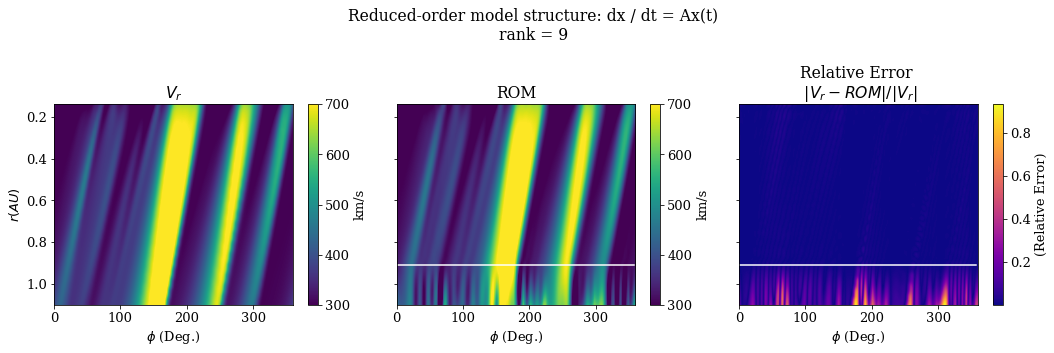

In [37]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r[-1].to(u.AU).value, 
                                    r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("ROM")
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('(Relative Error)', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()
plt.savefig("figs/linear_2d_reconstruction_shifted_operator_inference_mhd_A.png")

In [38]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.023526858148772267


# Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$

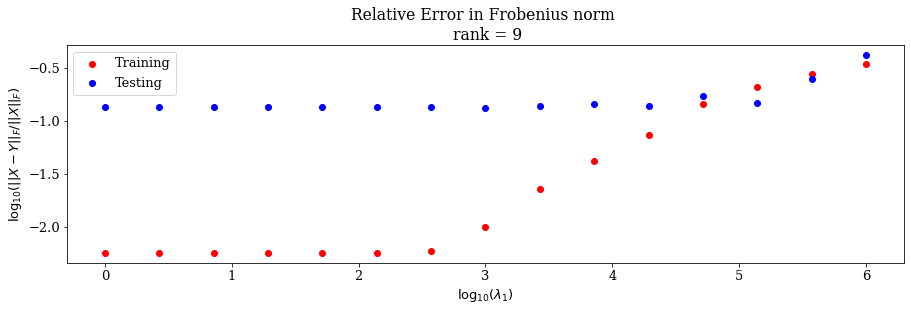

In [39]:
fig, ax = plt.subplots(figsize=(15, 4))

for coeff in 10**np.linspace(0, 6, 15):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, :l], X_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, l:], X_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm \n rank = " + str(rank))
_ = plt.legend()

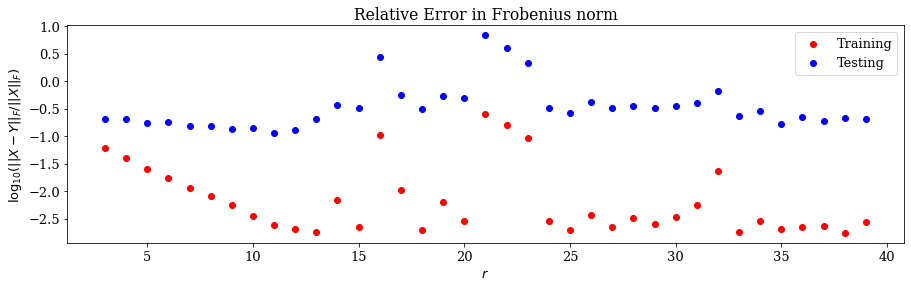

In [40]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(3, 40):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1E1)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, :l], X_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, l:], X_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$r$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

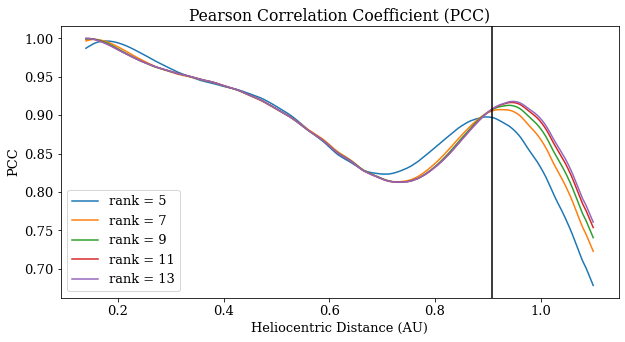

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))

for r_val in np.arange(5, 15,2):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=5e4)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        pcc_vec = np.zeros(len(r))
        for jj in range(len(r)):
            pcc_vec[jj] = stats.pearsonr(V[:, jj], X_ROM[:, jj])[0]
        
        ax.plot(r.to(u.AU).value, pcc_vec, label="rank = " + str(int(r_val)))
        
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")
plt.legend()


fig.savefig("figs/pcc_rank_opinf_mhd.png", dpi=500, bbox_inches='tight')

# Quadratic ROM

In [42]:
# Calculate the cumulative energy.
thresh = .99

cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 9


In [43]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="cAH")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=1E5)                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


In [44]:
V_ROM = X_ROM

IndexError: index 250 is out of bounds for axis 1 with size 241

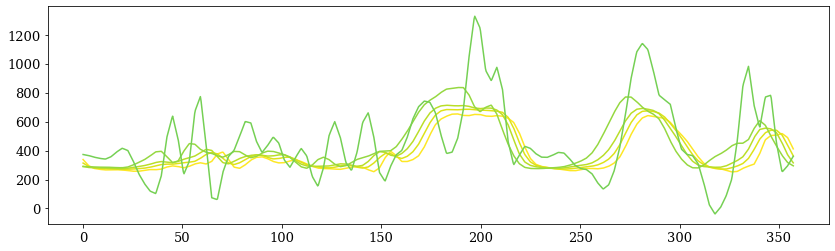

In [45]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel="$\phi$ + s (Deg.)")

In [ ]:
plot_heat_data(V_ROM, "ROM Output", variable="v")

In [ ]:
sample_columns = np.arange(0, len(r_new), int(len(r_new)/7))
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p_new*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"ref $r$ = "+
            str(round(r_new[j].to(u.AU).value,2)) + " AU")
    ax.plot(p_new*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=rf"ROM $r$" + "=" + 
            str(round(r_new[j].to(u.AU).value,2)) + " AU)")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=15)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("figs/opinf_results_quadratic_cAH.png", dpi=500, bbox_inches='tight')

In [ ]:
V.shape

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                    r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_ylabel(r"$r (AU)$")
ax[1].set_title("ROM")
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_ylabel(r"$r (R_\odot)$")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p_new)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

fig.savefig("figs/shifted_opinf_results_quadratic_2D_profile_cAH.png", dpi=500, bbox_inches='tight')

In [ ]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))

for coeff in 10**np.linspace(3, 11, 11):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, :l], X_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, l:], X_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(5, 20):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="cAH")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, :l], X_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, l:], X_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$r$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

# Sensitivity to Training Data

* **Test 1**: 120 training snapshots. 

* **Test 2**: 150 training snapshots. 

* **Test 3**: 180 training snapshots.

In [ ]:
# initialize the training length. 
l1, l2, l3 = int(0.5*len(r_new)), int(0.6*len(r_new)), int(0.7*len(r_new))


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [ ]:
r_train1 = r_new[:l1]
r_test1 = r_new[l1:-1]

r_train2 = r_new[:l2]
r_test2 = r_new[l2:-1]

r_train3 = r_new[:l3]
r_test3 = r_new[l3:-1]

In [ ]:
# l1 = compute the results for quadradic with 3 modes.
rank=10
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1E6)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1E6)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.


# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1E6)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, X_ROM1)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err1), "-o", c="b", label="$l_{1}$ = " + str(round(r_new[l1].to(u.AU).value, 2)))

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, X_ROM2)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err2), "-o", c="r", label="$l_{2}$ = " + str(round(r_new[l2].to(u.AU).value, 2)))

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, X_ROM3)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err3), "-o", c="g", label="$l_{3}$ = " + str(round(r_new[l3].to(u.AU).value, 2)))

_ = ax.axvline(r_train1[-1].to(u.AU).value, c="b")
_ = ax.axvline(r_train2[-1].to(u.AU).value, c="r")
_ = ax.axvline(r_train3[-1].to(u.AU).value, c="g")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.legend()
plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()